In [1]:
from google.colab import drive
drive.mount('/content/drive')
main_dir = 'drive/MyDrive/GSN/churn_text_prediction'

Mounted at /content/drive


In [2]:
import os
os.chdir(main_dir)

In [ ]:
!pip install transformers sentence_transformers tokenizers

In [3]:
from sentence_transformers import SentenceTransformer

ModuleNotFoundError: ignored

In [3]:
import yaml
import pandas as pd
from pathlib import Path
import numpy as np

In [4]:
os.chdir('scripts')

In [5]:
with open("../model/google/params.yaml", "r") as params_file:
    params_google = yaml.safe_load(params_file)
with open("../model/deepl/params.yaml", "r") as params_file:
    params_deepl = yaml.safe_load(params_file)

In [6]:
import pickle

Wczytanie danych przetłumaczonych

In [ ]:
df_text_google = pd.read_csv(Path(params_google['data_dir'], 'df_text_google.csv'))
df_text_deepl = pd.read_csv(Path(params_deepl['data_dir'], 'df_text_deepl.csv'))

Stwórz datasety

In [ ]:
def create_joint_dataset(
    df_categorical, 
    df_text
):
    df_text_no = df_text[df_text.churn == 'no'].reset_index(drop=True)
    df_text_yes = df_text[df_text.churn == 'yes'].reset_index(drop=True)

    df_cat_no = df_categorical[df_categorical.churn == 'no'].reset_index(drop=True)[:len(df_text_no)]
    df_cat_yes = df_categorical[df_categorical.churn == 'yes'].reset_index(drop=True)[:len(df_text_yes)]

    df_no = pd.concat([df_text_no, df_cat_no.iloc[:,:-1]], axis=1)
    df_yes = pd.concat([df_text_yes, df_cat_yes.iloc[:,:-1]], axis=1)

    df = pd.concat([df_no, df_yes], axis=0)

    # shuffle data
    df = df.sample(frac=1).reset_index(drop=True)

    return df

In [ ]:
# load data
df_categorical = pd.read_csv(Path('../data', "train.csv"))

In [ ]:
# create joint dataset
df_google = create_joint_dataset(df_categorical, df_text_google)
df_deepl = create_joint_dataset(df_categorical, df_text_deepl)

In [7]:
from sklearn.model_selection import train_test_split
import json

In [8]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

In [9]:
import joblib

In [12]:
from transformers import AutoTokenizer, AutoModel
# from transformers import *
import torch
from tqdm.notebook import tqdm

In [10]:
def extract_labels(
    data,
    label_name
):
    labels = []
    for sample in data:
        value = sample[label_name]
        labels.append(value)
    labels = np.array(labels).astype('int')

    return labels.reshape(labels.shape[0],-1)


def convert_label(
    df
):
    df.churn = df.churn.replace("no", 0)
    df.churn = df.churn.replace("yes", 1)
    return df

def split_data(
    df,
    label_name,
    test_size
):
    """Splits data and creates json format.
    """
    
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(columns=[label_name], axis=1), 
        df[label_name], 
        test_size=test_size, 
        random_state=123, 
        stratify=df[label_name])
    X_train[label_name] = y_train
    X_test[label_name] = y_test
        
    return X_train, X_test

def save_feature_names(
    numerical_feature_names,
    categorical_feature_names,
    textual_feature_names,
    filepath
):
    feature_names = {
        'numerical': numerical_feature_names,
        'categorical': categorical_feature_names,
        'textual': textual_feature_names
    }
    with open(filepath, 'w') as f:
        json.dump(feature_names, f)


def load_feature_names(filepath):
    with open(filepath, 'r') as f:
        feature_names = json.load(f)
    numerical_feature_names = feature_names['numerical']
    categorical_feature_names = feature_names['categorical']
    textual_feature_names = feature_names['textual']
    return numerical_feature_names, categorical_feature_names, textual_feature_names


def get_feature_names(
    df
):
    num_columns = df.select_dtypes(include=np.number).columns.tolist()
    numerical_feature_names = [i for i in num_columns if i not in ['churn']]

    cat_columns = df.select_dtypes(include='object').columns.tolist()
    categorical_feature_names = [i for i in cat_columns if i not in ['chat_log']]

    textual_feature_names = ['chat_log']
    label_name = 'churn'

    return numerical_feature_names, categorical_feature_names, textual_feature_names, label_name
    

In [14]:
class PolishBertEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, model_name='dkleczek/bert-base-polish-cased-v1'):
        self.model = AutoModel.from_pretrained(model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

    #Mean Pooling - Take attention mask into account for correct averaging
    def mean_pooling(self, token_embeddings, attention_mask): 
        input_mask_expanded = attention_mask.unsqueeze(0).unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
   
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        encoded_input = self.tokenizer(X, padding=True, truncation=True, return_tensors='pt')['attention_mask']

        sentence_emb = []
        for sentence in tqdm(encoded_input):
          # Compute token embeddings
          with torch.no_grad():
            model_output = self.model(sentence.unsqueeze(0))[0] #First element of model_output contains all token embeddings
          
          sentence_embeddings= self.mean_pooling(model_output, sentence)# Perform pooling. In this case, mean pooling.
          sentence_emb.append(sentence_embeddings)
        return sentence_emb

In [11]:
def main_transformation(df, model_dir, use_existing=False, test_size=0.33):
  """
    Args:
        df: Pandas dataframe with raw data
        use_existing: Set to True if you want to use locally stored, 
        already prepared train/test data. Set to False if you want 
        to rerun the data preparation pipeline.
    Returns:
        Train and test data as well as train labels and test labels.
  """
  train_file = Path(model_dir, 'train.csv')
  labels_file = Path(model_dir, 'labels.csv')
  test_file = Path(model_dir, 'test.csv')
  labels_test_file = Path(model_dir, 'labels_test.csv')
  feature_names_file = Path(model_dir, "feature_names.json")
  oh_feature_names_file = Path(model_dir, "one_hot_feature_names.json")
  all_file_paths = [train_file, labels_file, test_file, labels_test_file,
                    feature_names_file, oh_feature_names_file]
  
  if use_existing == True and sum([file.exists() for file in all_file_paths])==6:
      features = np.array(pd.read_csv(train_file))
      labels = np.array(pd.read_csv(labels_file))
      features_test = np.array(pd.read_csv(test_file))
      labels_test = np.array(pd.read_csv(labels_test_file))
      print("Using already prepared data.")

  else:
      print("Running data preparation pipeline...")
      # convert label to binary numeric
      df = convert_label(df)

      #get features categorial names
      numerical_feature_names, categorical_feature_names, textual_feature_names, label_name = get_feature_names(df)

      #split data
      X_train, X_test = split_data(df, label_name, test_size)

      # extract features & label
      print('extracting features')
      numerical_features = X_train[numerical_feature_names].values
      categorical_features = X_train[categorical_feature_names].values
      textual_features = X_train[textual_feature_names].values
      textual_features = [str(chat[0]) for chat in textual_features.tolist()]

      labels = X_train[label_name].values
      
      # define preprocessors
      print('defining preprocessors')
      numerical_transformer = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=True)
      categorical_transformer = OneHotEncoder(handle_unknown="ignore")
      textual_transformer = PolishBertEncoder()

      # fit preprocessors
      print('fitting numerical_transformer')
      numerical_transformer.fit(numerical_features)
      print('saving numerical_transformer')
      joblib.dump(numerical_transformer, Path(model_dir, "numerical_transformer.joblib"))
      print('fitting categorical_transformer')
      categorical_transformer.fit(categorical_features)
      print('saving categorical_transformer')
      joblib.dump(categorical_transformer, Path(model_dir, "categorical_transformer.joblib"))

      # transform features
      print('transforming numerical_features')
      numerical_features = numerical_transformer.transform(numerical_features)
      print('transforming categorical_features')
      categorical_features = categorical_transformer.transform(categorical_features)
      print('transforming textual_features')
      textual_features = textual_transformer.transform(textual_features)

      numerical_features_test = X_test[numerical_feature_names].values
      categorical_features_test = X_test[categorical_feature_names].values
      textual_features_test = X_test[textual_feature_names].values
      textual_features_test = [str(chat[0]) for chat in textual_features_test.tolist()]
      
      labels_test = X_test[label_name].values
      
      # transform features (for test data)
      print('transforming numerical_features_test')
      numerical_features_test = numerical_transformer.transform(numerical_features_test)
      print('transforming categorical_features_test')
      categorical_features_test = categorical_transformer.transform(categorical_features_test)
      print('transforming textual_features_test')
      textual_features_test = textual_transformer.transform(textual_features_test)

      # concat features
      print('concatenating features')
      categorical_features = categorical_features.toarray()
      textual_features = np.array([t[0].squeeze(0).numpy() for t in textual_features])
      features = np.concatenate([
          numerical_features,
          categorical_features,
          textual_features
      ], axis=1)

      # concat features (test data)
      print('concatenating features of test data')
      categorical_features_test = categorical_features_test.toarray()
      textual_features_test = np.array([t[0].squeeze(0).numpy() for t in textual_features_test])
      features_test = np.concatenate([
          numerical_features_test,
          categorical_features_test,
          textual_features_test
      ], axis=1)

      # save to disk
      pd.DataFrame(features).to_csv(Path(model_dir, "train.csv"), index=False)
      pd.DataFrame(labels).to_csv(Path(model_dir, "labels.csv"), index=False)
      pd.DataFrame(features_test).to_csv(Path(model_dir, "test.csv"), index=False)
      pd.DataFrame(labels_test).to_csv(Path(model_dir, "labels_test.csv"), index=False)

      save_feature_names(
          numerical_feature_names,
          categorical_feature_names,
          textual_feature_names,
          Path(model_dir, "feature_names.json")
      )
      # one-hot encoded feature names (for feat_imp)
      save_feature_names(
          numerical_feature_names,
          categorical_transformer.get_feature_names().tolist(),
          textual_feature_names,
          Path(model_dir, "one_hot_feature_names.json")
      )

  return features, features_test, labels, labels_test

In [13]:
import train

In [19]:
def plot_train_stats(
        params
):
    model_dir = params['model_dir']
    scores_df = pd.read_csv(Path(model_dir, 'training_scores.csv'))
    scores_df.plot(xlabel='Epochs', ylabel='AUC Score', title='AUC Score')
    return None


# Googlowe tłumaczenie

In [12]:
data_dir = params_google['data_dir']
model_dir = params_google['model_dir']
df_google = pd.read_csv(Path(data_dir, "churn_dataset_google.csv"))
X_train, X_test, y_train, y_test = main_transformation(df_google, params_google['model_dir'], use_existing=True, test_size=0.33)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

Using already prepared data.


((2233, 841), (1100, 841), (2233, 1), (1100, 1))

In [14]:
train.train(
    X=X_train,
    y=y_train,
    X_test=X_test,
    y_test=y_test,
    params = params_google
)

starting epoch:  1
Train Epoch: 1, train-auc-score: 0.7339


INFO:train:Train Epoch: 1, train-auc-score: 0.7339


test_auc_score: 0.7900


INFO:train:test_auc_score: 0.7900


starting epoch:  2
Train Epoch: 2, train-auc-score: 0.7643


INFO:train:Train Epoch: 2, train-auc-score: 0.7643


test_auc_score: 0.8158


INFO:train:test_auc_score: 0.8158


starting epoch:  3
Train Epoch: 3, train-auc-score: 0.7739


INFO:train:Train Epoch: 3, train-auc-score: 0.7739


test_auc_score: 0.8190


INFO:train:test_auc_score: 0.8190


starting epoch:  4
Train Epoch: 4, train-auc-score: 0.8105


INFO:train:Train Epoch: 4, train-auc-score: 0.8105


test_auc_score: 0.8203


INFO:train:test_auc_score: 0.8203


starting epoch:  5
Train Epoch: 5, train-auc-score: 0.8264


INFO:train:Train Epoch: 5, train-auc-score: 0.8264


test_auc_score: 0.8068


INFO:train:test_auc_score: 0.8068


starting epoch:  6
Train Epoch: 6, train-auc-score: 0.8402


INFO:train:Train Epoch: 6, train-auc-score: 0.8402


test_auc_score: 0.8309


INFO:train:test_auc_score: 0.8309


starting epoch:  7
Train Epoch: 7, train-auc-score: 0.8344


INFO:train:Train Epoch: 7, train-auc-score: 0.8344


test_auc_score: 0.8068


INFO:train:test_auc_score: 0.8068


starting epoch:  8
Train Epoch: 8, train-auc-score: 0.8591


INFO:train:Train Epoch: 8, train-auc-score: 0.8591


test_auc_score: 0.8443


INFO:train:test_auc_score: 0.8443


starting epoch:  9
Train Epoch: 9, train-auc-score: 0.8643


INFO:train:Train Epoch: 9, train-auc-score: 0.8643


test_auc_score: 0.8553


INFO:train:test_auc_score: 0.8553


starting epoch:  10
Train Epoch: 10, train-auc-score: 0.8705


INFO:train:Train Epoch: 10, train-auc-score: 0.8705


test_auc_score: 0.8630


INFO:train:test_auc_score: 0.8630


starting epoch:  11
Train Epoch: 11, train-auc-score: 0.8714


INFO:train:Train Epoch: 11, train-auc-score: 0.8714


test_auc_score: 0.8653


INFO:train:test_auc_score: 0.8653


starting epoch:  12
Train Epoch: 12, train-auc-score: 0.8794


INFO:train:Train Epoch: 12, train-auc-score: 0.8794


test_auc_score: 0.8556


INFO:train:test_auc_score: 0.8556


starting epoch:  13
Train Epoch: 13, train-auc-score: 0.8754


INFO:train:Train Epoch: 13, train-auc-score: 0.8754


test_auc_score: 0.8649


INFO:train:test_auc_score: 0.8649


starting epoch:  14
Train Epoch: 14, train-auc-score: 0.8865


INFO:train:Train Epoch: 14, train-auc-score: 0.8865


test_auc_score: 0.8637


INFO:train:test_auc_score: 0.8637


starting epoch:  15
Train Epoch: 15, train-auc-score: 0.8891


INFO:train:Train Epoch: 15, train-auc-score: 0.8891


test_auc_score: 0.8501


INFO:train:test_auc_score: 0.8501


starting epoch:  16
Train Epoch: 16, train-auc-score: 0.8731


INFO:train:Train Epoch: 16, train-auc-score: 0.8731


test_auc_score: 0.8173


INFO:train:test_auc_score: 0.8173


starting epoch:  17
Train Epoch: 17, train-auc-score: 0.9016


INFO:train:Train Epoch: 17, train-auc-score: 0.9016


test_auc_score: 0.8772


INFO:train:test_auc_score: 0.8772


starting epoch:  18
Train Epoch: 18, train-auc-score: 0.8992


INFO:train:Train Epoch: 18, train-auc-score: 0.8992


test_auc_score: 0.8747


INFO:train:test_auc_score: 0.8747


starting epoch:  19
Train Epoch: 19, train-auc-score: 0.9095


INFO:train:Train Epoch: 19, train-auc-score: 0.9095


test_auc_score: 0.8698


INFO:train:test_auc_score: 0.8698


starting epoch:  20
Train Epoch: 20, train-auc-score: 0.9125


INFO:train:Train Epoch: 20, train-auc-score: 0.9125


test_auc_score: 0.8696


INFO:train:test_auc_score: 0.8696


starting epoch:  21
Train Epoch: 21, train-auc-score: 0.9118


INFO:train:Train Epoch: 21, train-auc-score: 0.9118


test_auc_score: 0.8726


INFO:train:test_auc_score: 0.8726


starting epoch:  22
Train Epoch: 22, train-auc-score: 0.9206


INFO:train:Train Epoch: 22, train-auc-score: 0.9206


test_auc_score: 0.8793


INFO:train:test_auc_score: 0.8793


starting epoch:  23
Train Epoch: 23, train-auc-score: 0.9197


INFO:train:Train Epoch: 23, train-auc-score: 0.9197


test_auc_score: 0.8796


INFO:train:test_auc_score: 0.8796


starting epoch:  24
Train Epoch: 24, train-auc-score: 0.9183


INFO:train:Train Epoch: 24, train-auc-score: 0.9183


test_auc_score: 0.8827


INFO:train:test_auc_score: 0.8827


starting epoch:  25
Train Epoch: 25, train-auc-score: 0.9303


INFO:train:Train Epoch: 25, train-auc-score: 0.9303


test_auc_score: 0.8759


INFO:train:test_auc_score: 0.8759


starting epoch:  26
Train Epoch: 26, train-auc-score: 0.9242


INFO:train:Train Epoch: 26, train-auc-score: 0.9242


test_auc_score: 0.8764


INFO:train:test_auc_score: 0.8764


starting epoch:  27
Train Epoch: 27, train-auc-score: 0.9291


INFO:train:Train Epoch: 27, train-auc-score: 0.9291


test_auc_score: 0.8817


INFO:train:test_auc_score: 0.8817


starting epoch:  28
Train Epoch: 28, train-auc-score: 0.9241


INFO:train:Train Epoch: 28, train-auc-score: 0.9241


test_auc_score: 0.8772


INFO:train:test_auc_score: 0.8772


starting epoch:  29
Train Epoch: 29, train-auc-score: 0.9252


INFO:train:Train Epoch: 29, train-auc-score: 0.9252


test_auc_score: 0.8748


INFO:train:test_auc_score: 0.8748


starting epoch:  30
Train Epoch: 30, train-auc-score: 0.9232


INFO:train:Train Epoch: 30, train-auc-score: 0.9232


test_auc_score: 0.8853


INFO:train:test_auc_score: 0.8853


starting epoch:  31
Train Epoch: 31, train-auc-score: 0.9266


INFO:train:Train Epoch: 31, train-auc-score: 0.9266


test_auc_score: 0.8834


INFO:train:test_auc_score: 0.8834


starting epoch:  32
Train Epoch: 32, train-auc-score: 0.9269


INFO:train:Train Epoch: 32, train-auc-score: 0.9269


test_auc_score: 0.8749


INFO:train:test_auc_score: 0.8749


starting epoch:  33
Train Epoch: 33, train-auc-score: 0.9299


INFO:train:Train Epoch: 33, train-auc-score: 0.9299


test_auc_score: 0.8771


INFO:train:test_auc_score: 0.8771


starting epoch:  34
Train Epoch: 34, train-auc-score: 0.9343


INFO:train:Train Epoch: 34, train-auc-score: 0.9343


test_auc_score: 0.8808


INFO:train:test_auc_score: 0.8808


starting epoch:  35
Train Epoch: 35, train-auc-score: 0.9320


INFO:train:Train Epoch: 35, train-auc-score: 0.9320


test_auc_score: 0.8903


INFO:train:test_auc_score: 0.8903


starting epoch:  36
Train Epoch: 36, train-auc-score: 0.9311


INFO:train:Train Epoch: 36, train-auc-score: 0.9311


test_auc_score: 0.8797


INFO:train:test_auc_score: 0.8797


starting epoch:  37
Train Epoch: 37, train-auc-score: 0.9188


INFO:train:Train Epoch: 37, train-auc-score: 0.9188


test_auc_score: 0.8700


INFO:train:test_auc_score: 0.8700


starting epoch:  38
Train Epoch: 38, train-auc-score: 0.9298


INFO:train:Train Epoch: 38, train-auc-score: 0.9298


test_auc_score: 0.8717


INFO:train:test_auc_score: 0.8717


starting epoch:  39
Train Epoch: 39, train-auc-score: 0.9275


INFO:train:Train Epoch: 39, train-auc-score: 0.9275


test_auc_score: 0.8764


INFO:train:test_auc_score: 0.8764


starting epoch:  40
Train Epoch: 40, train-auc-score: 0.9288


INFO:train:Train Epoch: 40, train-auc-score: 0.9288


test_auc_score: 0.8827


INFO:train:test_auc_score: 0.8827


starting epoch:  41
Train Epoch: 41, train-auc-score: 0.9342


INFO:train:Train Epoch: 41, train-auc-score: 0.9342


test_auc_score: 0.8776


INFO:train:test_auc_score: 0.8776


starting epoch:  42
Train Epoch: 42, train-auc-score: 0.9365


INFO:train:Train Epoch: 42, train-auc-score: 0.9365


test_auc_score: 0.8662


INFO:train:test_auc_score: 0.8662


starting epoch:  43
Train Epoch: 43, train-auc-score: 0.9235


INFO:train:Train Epoch: 43, train-auc-score: 0.9235


test_auc_score: 0.8857


INFO:train:test_auc_score: 0.8857


starting epoch:  44
Train Epoch: 44, train-auc-score: 0.9366


INFO:train:Train Epoch: 44, train-auc-score: 0.9366


test_auc_score: 0.8829


INFO:train:test_auc_score: 0.8829


starting epoch:  45
Train Epoch: 45, train-auc-score: 0.9288


INFO:train:Train Epoch: 45, train-auc-score: 0.9288


test_auc_score: 0.8844


INFO:train:test_auc_score: 0.8844


starting epoch:  46
Train Epoch: 46, train-auc-score: 0.9284


INFO:train:Train Epoch: 46, train-auc-score: 0.9284


test_auc_score: 0.8798


INFO:train:test_auc_score: 0.8798


starting epoch:  47
Train Epoch: 47, train-auc-score: 0.9314


INFO:train:Train Epoch: 47, train-auc-score: 0.9314


test_auc_score: 0.8694


INFO:train:test_auc_score: 0.8694


starting epoch:  48
Train Epoch: 48, train-auc-score: 0.9321


INFO:train:Train Epoch: 48, train-auc-score: 0.9321


test_auc_score: 0.8697


INFO:train:test_auc_score: 0.8697


starting epoch:  49
Train Epoch: 49, train-auc-score: 0.9261


INFO:train:Train Epoch: 49, train-auc-score: 0.9261


test_auc_score: 0.8763


INFO:train:test_auc_score: 0.8763


starting epoch:  50
Train Epoch: 50, train-auc-score: 0.9274


INFO:train:Train Epoch: 50, train-auc-score: 0.9274


test_auc_score: 0.8673


INFO:train:test_auc_score: 0.8673


starting epoch:  51
Train Epoch: 51, train-auc-score: 0.9334


INFO:train:Train Epoch: 51, train-auc-score: 0.9334


test_auc_score: 0.8658


INFO:train:test_auc_score: 0.8658


starting epoch:  52
Train Epoch: 52, train-auc-score: 0.9284


INFO:train:Train Epoch: 52, train-auc-score: 0.9284


test_auc_score: 0.8741


INFO:train:test_auc_score: 0.8741


starting epoch:  53
Train Epoch: 53, train-auc-score: 0.9333


INFO:train:Train Epoch: 53, train-auc-score: 0.9333


test_auc_score: 0.8851


INFO:train:test_auc_score: 0.8851


starting epoch:  54
Train Epoch: 54, train-auc-score: 0.9326


INFO:train:Train Epoch: 54, train-auc-score: 0.9326


test_auc_score: 0.8685


INFO:train:test_auc_score: 0.8685


starting epoch:  55
Train Epoch: 55, train-auc-score: 0.9209


INFO:train:Train Epoch: 55, train-auc-score: 0.9209


test_auc_score: 0.8634


INFO:train:test_auc_score: 0.8634


starting epoch:  56
Train Epoch: 56, train-auc-score: 0.9317


INFO:train:Train Epoch: 56, train-auc-score: 0.9317


test_auc_score: 0.8695


INFO:train:test_auc_score: 0.8695


starting epoch:  57
Train Epoch: 57, train-auc-score: 0.9300


INFO:train:Train Epoch: 57, train-auc-score: 0.9300


test_auc_score: 0.8719


INFO:train:test_auc_score: 0.8719


starting epoch:  58
Train Epoch: 58, train-auc-score: 0.9275


INFO:train:Train Epoch: 58, train-auc-score: 0.9275


test_auc_score: 0.8728


INFO:train:test_auc_score: 0.8728


starting epoch:  59
Train Epoch: 59, train-auc-score: 0.9320


INFO:train:Train Epoch: 59, train-auc-score: 0.9320


test_auc_score: 0.8722


INFO:train:test_auc_score: 0.8722


starting epoch:  60
Train Epoch: 60, train-auc-score: 0.9297


INFO:train:Train Epoch: 60, train-auc-score: 0.9297


test_auc_score: 0.8697


INFO:train:test_auc_score: 0.8697


starting epoch:  61
Train Epoch: 61, train-auc-score: 0.9360


INFO:train:Train Epoch: 61, train-auc-score: 0.9360


test_auc_score: 0.8744


INFO:train:test_auc_score: 0.8744


starting epoch:  62
Train Epoch: 62, train-auc-score: 0.9304


INFO:train:Train Epoch: 62, train-auc-score: 0.9304


test_auc_score: 0.8539


INFO:train:test_auc_score: 0.8539


starting epoch:  63
Train Epoch: 63, train-auc-score: 0.9246


INFO:train:Train Epoch: 63, train-auc-score: 0.9246


test_auc_score: 0.8599


INFO:train:test_auc_score: 0.8599


starting epoch:  64
Train Epoch: 64, train-auc-score: 0.9267


INFO:train:Train Epoch: 64, train-auc-score: 0.9267


test_auc_score: 0.8757


INFO:train:test_auc_score: 0.8757


starting epoch:  65
Train Epoch: 65, train-auc-score: 0.9301


INFO:train:Train Epoch: 65, train-auc-score: 0.9301


test_auc_score: 0.8736


INFO:train:test_auc_score: 0.8736


starting epoch:  66
Train Epoch: 66, train-auc-score: 0.9283


INFO:train:Train Epoch: 66, train-auc-score: 0.9283


test_auc_score: 0.8571


INFO:train:test_auc_score: 0.8571


starting epoch:  67
Train Epoch: 67, train-auc-score: 0.9333


INFO:train:Train Epoch: 67, train-auc-score: 0.9333


test_auc_score: 0.8795


INFO:train:test_auc_score: 0.8795


starting epoch:  68
Train Epoch: 68, train-auc-score: 0.9292


INFO:train:Train Epoch: 68, train-auc-score: 0.9292


test_auc_score: 0.8666


INFO:train:test_auc_score: 0.8666


starting epoch:  69
Train Epoch: 69, train-auc-score: 0.9344


INFO:train:Train Epoch: 69, train-auc-score: 0.9344


test_auc_score: 0.8765


INFO:train:test_auc_score: 0.8765


starting epoch:  70
Train Epoch: 70, train-auc-score: 0.9244


INFO:train:Train Epoch: 70, train-auc-score: 0.9244


test_auc_score: 0.8625


INFO:train:test_auc_score: 0.8625


starting epoch:  71
Train Epoch: 71, train-auc-score: 0.9333


INFO:train:Train Epoch: 71, train-auc-score: 0.9333


test_auc_score: 0.8619


INFO:train:test_auc_score: 0.8619


starting epoch:  72
Train Epoch: 72, train-auc-score: 0.9291


INFO:train:Train Epoch: 72, train-auc-score: 0.9291


test_auc_score: 0.8637


INFO:train:test_auc_score: 0.8637


starting epoch:  73
Train Epoch: 73, train-auc-score: 0.9299


INFO:train:Train Epoch: 73, train-auc-score: 0.9299


test_auc_score: 0.8662


INFO:train:test_auc_score: 0.8662


starting epoch:  74
Train Epoch: 74, train-auc-score: 0.9345


INFO:train:Train Epoch: 74, train-auc-score: 0.9345


test_auc_score: 0.8634


INFO:train:test_auc_score: 0.8634


starting epoch:  75
Train Epoch: 75, train-auc-score: 0.9303


INFO:train:Train Epoch: 75, train-auc-score: 0.9303


test_auc_score: 0.8794


INFO:train:test_auc_score: 0.8794


starting epoch:  76
Train Epoch: 76, train-auc-score: 0.9366


INFO:train:Train Epoch: 76, train-auc-score: 0.9366


test_auc_score: 0.8599


INFO:train:test_auc_score: 0.8599


starting epoch:  77
Train Epoch: 77, train-auc-score: 0.9385


INFO:train:Train Epoch: 77, train-auc-score: 0.9385


test_auc_score: 0.8748


INFO:train:test_auc_score: 0.8748


starting epoch:  78
Train Epoch: 78, train-auc-score: 0.9345


INFO:train:Train Epoch: 78, train-auc-score: 0.9345


test_auc_score: 0.8771


INFO:train:test_auc_score: 0.8771


starting epoch:  79
Train Epoch: 79, train-auc-score: 0.9335


INFO:train:Train Epoch: 79, train-auc-score: 0.9335


test_auc_score: 0.8751


INFO:train:test_auc_score: 0.8751


starting epoch:  80
Train Epoch: 80, train-auc-score: 0.9232


INFO:train:Train Epoch: 80, train-auc-score: 0.9232


test_auc_score: 0.8728


INFO:train:test_auc_score: 0.8728


starting epoch:  81
Train Epoch: 81, train-auc-score: 0.9271


INFO:train:Train Epoch: 81, train-auc-score: 0.9271


test_auc_score: 0.8602


INFO:train:test_auc_score: 0.8602


starting epoch:  82
Train Epoch: 82, train-auc-score: 0.9349


INFO:train:Train Epoch: 82, train-auc-score: 0.9349


test_auc_score: 0.8731


INFO:train:test_auc_score: 0.8731


starting epoch:  83
Train Epoch: 83, train-auc-score: 0.9382


INFO:train:Train Epoch: 83, train-auc-score: 0.9382


test_auc_score: 0.8737


INFO:train:test_auc_score: 0.8737


starting epoch:  84
Train Epoch: 84, train-auc-score: 0.9262


INFO:train:Train Epoch: 84, train-auc-score: 0.9262


test_auc_score: 0.8668


INFO:train:test_auc_score: 0.8668


starting epoch:  85
Train Epoch: 85, train-auc-score: 0.9240


INFO:train:Train Epoch: 85, train-auc-score: 0.9240


test_auc_score: 0.8744


INFO:train:test_auc_score: 0.8744


starting epoch:  86
Train Epoch: 86, train-auc-score: 0.9345


INFO:train:Train Epoch: 86, train-auc-score: 0.9345


test_auc_score: 0.8680


INFO:train:test_auc_score: 0.8680


starting epoch:  87
Train Epoch: 87, train-auc-score: 0.9286


INFO:train:Train Epoch: 87, train-auc-score: 0.9286


test_auc_score: 0.8654


INFO:train:test_auc_score: 0.8654


starting epoch:  88
Train Epoch: 88, train-auc-score: 0.9413


INFO:train:Train Epoch: 88, train-auc-score: 0.9413


test_auc_score: 0.8720


INFO:train:test_auc_score: 0.8720


starting epoch:  89
Train Epoch: 89, train-auc-score: 0.9258


INFO:train:Train Epoch: 89, train-auc-score: 0.9258


test_auc_score: 0.8781


INFO:train:test_auc_score: 0.8781


starting epoch:  90
Train Epoch: 90, train-auc-score: 0.9311


INFO:train:Train Epoch: 90, train-auc-score: 0.9311


test_auc_score: 0.8732


INFO:train:test_auc_score: 0.8732


starting epoch:  91
Train Epoch: 91, train-auc-score: 0.9340


INFO:train:Train Epoch: 91, train-auc-score: 0.9340


test_auc_score: 0.8803


INFO:train:test_auc_score: 0.8803


starting epoch:  92
Train Epoch: 92, train-auc-score: 0.9248


INFO:train:Train Epoch: 92, train-auc-score: 0.9248


test_auc_score: 0.8634


INFO:train:test_auc_score: 0.8634


starting epoch:  93
Train Epoch: 93, train-auc-score: 0.9335


INFO:train:Train Epoch: 93, train-auc-score: 0.9335


test_auc_score: 0.8595


INFO:train:test_auc_score: 0.8595


starting epoch:  94
Train Epoch: 94, train-auc-score: 0.9349


INFO:train:Train Epoch: 94, train-auc-score: 0.9349


test_auc_score: 0.8596


INFO:train:test_auc_score: 0.8596


starting epoch:  95
Train Epoch: 95, train-auc-score: 0.9330


INFO:train:Train Epoch: 95, train-auc-score: 0.9330


test_auc_score: 0.8657


INFO:train:test_auc_score: 0.8657


starting epoch:  96
Train Epoch: 96, train-auc-score: 0.9332


INFO:train:Train Epoch: 96, train-auc-score: 0.9332


test_auc_score: 0.8594


INFO:train:test_auc_score: 0.8594


starting epoch:  97
Train Epoch: 97, train-auc-score: 0.9314


INFO:train:Train Epoch: 97, train-auc-score: 0.9314


test_auc_score: 0.8610


INFO:train:test_auc_score: 0.8610


starting epoch:  98
Train Epoch: 98, train-auc-score: 0.9326


INFO:train:Train Epoch: 98, train-auc-score: 0.9326


test_auc_score: 0.8596


INFO:train:test_auc_score: 0.8596


starting epoch:  99
Train Epoch: 99, train-auc-score: 0.9340


INFO:train:Train Epoch: 99, train-auc-score: 0.9340


test_auc_score: 0.8654


INFO:train:test_auc_score: 0.8654


starting epoch:  100
Train Epoch: 100, train-auc-score: 0.9351


INFO:train:Train Epoch: 100, train-auc-score: 0.9351


test_auc_score: 0.8687


INFO:train:test_auc_score: 0.8687


saving scores
saving model


In [15]:
scores_df = pd.read_csv(Path(model_dir, 'training_scores.csv'))

In [16]:
scores_df

,train_scores,test_scores
0,0.733888,0.789953
1,0.764266,0.815765
2,0.773872,0.818987
3,0.810547,0.820284
4,0.826417,0.806803
...,...,...
95,0.933184,0.859436
96,0.931364,0.861040
97,0.932634,0.859610
98,0.934003,0.865408


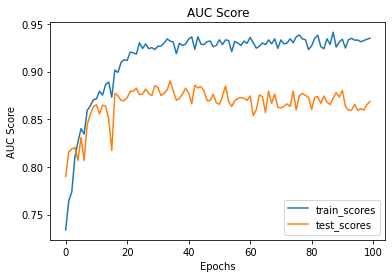

In [20]:
plot_train_stats(params_google)

# Deepl tlumaczenie

In [21]:
data_dir = params_deepl['data_dir']
model_dir = params_deepl['model_dir']
df_deepl = pd.read_csv(Path(data_dir, "churn_dataset_deepl.csv"))
X_train, X_test, y_train, y_test = main_transformation(df_deepl, params_deepl['model_dir'], use_existing=True, test_size=0.33)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

Using already prepared data.


((2233, 841), (1100, 841), (2233, 1), (1100, 1))

In [23]:
train.train(
    X=X_train,
    y=y_train,
    X_test=X_test,
    y_test=y_test,
    params=params_deepl
)

starting epoch:  1
Train Epoch: 1, train-auc-score: 0.5978


INFO:train:Train Epoch: 1, train-auc-score: 0.5978


test_auc_score: 0.6286


INFO:train:test_auc_score: 0.6286


starting epoch:  2
Train Epoch: 2, train-auc-score: 0.6109


INFO:train:Train Epoch: 2, train-auc-score: 0.6109


test_auc_score: 0.6318


INFO:train:test_auc_score: 0.6318


starting epoch:  3
Train Epoch: 3, train-auc-score: 0.6215


INFO:train:Train Epoch: 3, train-auc-score: 0.6215


test_auc_score: 0.6642


INFO:train:test_auc_score: 0.6642


starting epoch:  4
Train Epoch: 4, train-auc-score: 0.6353


INFO:train:Train Epoch: 4, train-auc-score: 0.6353


test_auc_score: 0.6585


INFO:train:test_auc_score: 0.6585


starting epoch:  5
Train Epoch: 5, train-auc-score: 0.6546


INFO:train:Train Epoch: 5, train-auc-score: 0.6546


test_auc_score: 0.6828


INFO:train:test_auc_score: 0.6828


starting epoch:  6
Train Epoch: 6, train-auc-score: 0.6412


INFO:train:Train Epoch: 6, train-auc-score: 0.6412


test_auc_score: 0.6692


INFO:train:test_auc_score: 0.6692


starting epoch:  7
Train Epoch: 7, train-auc-score: 0.6748


INFO:train:Train Epoch: 7, train-auc-score: 0.6748


test_auc_score: 0.6943


INFO:train:test_auc_score: 0.6943


starting epoch:  8
Train Epoch: 8, train-auc-score: 0.6692


INFO:train:Train Epoch: 8, train-auc-score: 0.6692


test_auc_score: 0.6976


INFO:train:test_auc_score: 0.6976


starting epoch:  9
Train Epoch: 9, train-auc-score: 0.6447


INFO:train:Train Epoch: 9, train-auc-score: 0.6447


test_auc_score: 0.6592


INFO:train:test_auc_score: 0.6592


starting epoch:  10
Train Epoch: 10, train-auc-score: 0.6997


INFO:train:Train Epoch: 10, train-auc-score: 0.6997


test_auc_score: 0.7009


INFO:train:test_auc_score: 0.7009


starting epoch:  11
Train Epoch: 11, train-auc-score: 0.7504


INFO:train:Train Epoch: 11, train-auc-score: 0.7504


test_auc_score: 0.7690


INFO:train:test_auc_score: 0.7690


starting epoch:  12
Train Epoch: 12, train-auc-score: 0.7749


INFO:train:Train Epoch: 12, train-auc-score: 0.7749


test_auc_score: 0.7804


INFO:train:test_auc_score: 0.7804


starting epoch:  13
Train Epoch: 13, train-auc-score: 0.7820


INFO:train:Train Epoch: 13, train-auc-score: 0.7820


test_auc_score: 0.7936


INFO:train:test_auc_score: 0.7936


starting epoch:  14
Train Epoch: 14, train-auc-score: 0.7928


INFO:train:Train Epoch: 14, train-auc-score: 0.7928


test_auc_score: 0.8022


INFO:train:test_auc_score: 0.8022


starting epoch:  15
Train Epoch: 15, train-auc-score: 0.7945


INFO:train:Train Epoch: 15, train-auc-score: 0.7945


test_auc_score: 0.8077


INFO:train:test_auc_score: 0.8077


starting epoch:  16
Train Epoch: 16, train-auc-score: 0.8117


INFO:train:Train Epoch: 16, train-auc-score: 0.8117


test_auc_score: 0.8123


INFO:train:test_auc_score: 0.8123


starting epoch:  17
Train Epoch: 17, train-auc-score: 0.8181


INFO:train:Train Epoch: 17, train-auc-score: 0.8181


test_auc_score: 0.8192


INFO:train:test_auc_score: 0.8192


starting epoch:  18
Train Epoch: 18, train-auc-score: 0.8318


INFO:train:Train Epoch: 18, train-auc-score: 0.8318


test_auc_score: 0.8362


INFO:train:test_auc_score: 0.8362


starting epoch:  19
Train Epoch: 19, train-auc-score: 0.8421


INFO:train:Train Epoch: 19, train-auc-score: 0.8421


test_auc_score: 0.8299


INFO:train:test_auc_score: 0.8299


starting epoch:  20
Train Epoch: 20, train-auc-score: 0.8451


INFO:train:Train Epoch: 20, train-auc-score: 0.8451


test_auc_score: 0.8393


INFO:train:test_auc_score: 0.8393


starting epoch:  21
Train Epoch: 21, train-auc-score: 0.8507


INFO:train:Train Epoch: 21, train-auc-score: 0.8507


test_auc_score: 0.8450


INFO:train:test_auc_score: 0.8450


starting epoch:  22
Train Epoch: 22, train-auc-score: 0.8626


INFO:train:Train Epoch: 22, train-auc-score: 0.8626


test_auc_score: 0.8521


INFO:train:test_auc_score: 0.8521


starting epoch:  23
Train Epoch: 23, train-auc-score: 0.8658


INFO:train:Train Epoch: 23, train-auc-score: 0.8658


test_auc_score: 0.8475


INFO:train:test_auc_score: 0.8475


starting epoch:  24
Train Epoch: 24, train-auc-score: 0.8697


INFO:train:Train Epoch: 24, train-auc-score: 0.8697


test_auc_score: 0.8524


INFO:train:test_auc_score: 0.8524


starting epoch:  25
Train Epoch: 25, train-auc-score: 0.8694


INFO:train:Train Epoch: 25, train-auc-score: 0.8694


test_auc_score: 0.8505


INFO:train:test_auc_score: 0.8505


starting epoch:  26
Train Epoch: 26, train-auc-score: 0.8817


INFO:train:Train Epoch: 26, train-auc-score: 0.8817


test_auc_score: 0.8653


INFO:train:test_auc_score: 0.8653


starting epoch:  27
Train Epoch: 27, train-auc-score: 0.8756


INFO:train:Train Epoch: 27, train-auc-score: 0.8756


test_auc_score: 0.8577


INFO:train:test_auc_score: 0.8577


starting epoch:  28
Train Epoch: 28, train-auc-score: 0.8886


INFO:train:Train Epoch: 28, train-auc-score: 0.8886


test_auc_score: 0.8657


INFO:train:test_auc_score: 0.8657


starting epoch:  29
Train Epoch: 29, train-auc-score: 0.8796


INFO:train:Train Epoch: 29, train-auc-score: 0.8796


test_auc_score: 0.8622


INFO:train:test_auc_score: 0.8622


starting epoch:  30
Train Epoch: 30, train-auc-score: 0.8819


INFO:train:Train Epoch: 30, train-auc-score: 0.8819


test_auc_score: 0.8651


INFO:train:test_auc_score: 0.8651


starting epoch:  31
Train Epoch: 31, train-auc-score: 0.8906


INFO:train:Train Epoch: 31, train-auc-score: 0.8906


test_auc_score: 0.8731


INFO:train:test_auc_score: 0.8731


starting epoch:  32
Train Epoch: 32, train-auc-score: 0.8908


INFO:train:Train Epoch: 32, train-auc-score: 0.8908


test_auc_score: 0.8564


INFO:train:test_auc_score: 0.8564


starting epoch:  33
Train Epoch: 33, train-auc-score: 0.8829


INFO:train:Train Epoch: 33, train-auc-score: 0.8829


test_auc_score: 0.8480


INFO:train:test_auc_score: 0.8480


starting epoch:  34
Train Epoch: 34, train-auc-score: 0.8921


INFO:train:Train Epoch: 34, train-auc-score: 0.8921


test_auc_score: 0.8769


INFO:train:test_auc_score: 0.8769


starting epoch:  35
Train Epoch: 35, train-auc-score: 0.8954


INFO:train:Train Epoch: 35, train-auc-score: 0.8954


test_auc_score: 0.8726


INFO:train:test_auc_score: 0.8726


starting epoch:  36
Train Epoch: 36, train-auc-score: 0.8893


INFO:train:Train Epoch: 36, train-auc-score: 0.8893


test_auc_score: 0.8667


INFO:train:test_auc_score: 0.8667


starting epoch:  37
Train Epoch: 37, train-auc-score: 0.8925


INFO:train:Train Epoch: 37, train-auc-score: 0.8925


test_auc_score: 0.8775


INFO:train:test_auc_score: 0.8775


starting epoch:  38
Train Epoch: 38, train-auc-score: 0.8998


INFO:train:Train Epoch: 38, train-auc-score: 0.8998


test_auc_score: 0.8796


INFO:train:test_auc_score: 0.8796


starting epoch:  39
Train Epoch: 39, train-auc-score: 0.8985


INFO:train:Train Epoch: 39, train-auc-score: 0.8985


test_auc_score: 0.8750


INFO:train:test_auc_score: 0.8750


starting epoch:  40
Train Epoch: 40, train-auc-score: 0.8893


INFO:train:Train Epoch: 40, train-auc-score: 0.8893


test_auc_score: 0.8774


INFO:train:test_auc_score: 0.8774


starting epoch:  41
Train Epoch: 41, train-auc-score: 0.9060


INFO:train:Train Epoch: 41, train-auc-score: 0.9060


test_auc_score: 0.8729


INFO:train:test_auc_score: 0.8729


starting epoch:  42
Train Epoch: 42, train-auc-score: 0.9120


INFO:train:Train Epoch: 42, train-auc-score: 0.9120


test_auc_score: 0.8731


INFO:train:test_auc_score: 0.8731


starting epoch:  43
Train Epoch: 43, train-auc-score: 0.9013


INFO:train:Train Epoch: 43, train-auc-score: 0.9013


test_auc_score: 0.8743


INFO:train:test_auc_score: 0.8743


starting epoch:  44
Train Epoch: 44, train-auc-score: 0.9049


INFO:train:Train Epoch: 44, train-auc-score: 0.9049


test_auc_score: 0.8663


INFO:train:test_auc_score: 0.8663


starting epoch:  45
Train Epoch: 45, train-auc-score: 0.9076


INFO:train:Train Epoch: 45, train-auc-score: 0.9076


test_auc_score: 0.8715


INFO:train:test_auc_score: 0.8715


starting epoch:  46
Train Epoch: 46, train-auc-score: 0.9020


INFO:train:Train Epoch: 46, train-auc-score: 0.9020


test_auc_score: 0.8713


INFO:train:test_auc_score: 0.8713


starting epoch:  47
Train Epoch: 47, train-auc-score: 0.9042


INFO:train:Train Epoch: 47, train-auc-score: 0.9042


test_auc_score: 0.8675


INFO:train:test_auc_score: 0.8675


starting epoch:  48
Train Epoch: 48, train-auc-score: 0.9067


INFO:train:Train Epoch: 48, train-auc-score: 0.9067


test_auc_score: 0.8800


INFO:train:test_auc_score: 0.8800


starting epoch:  49
Train Epoch: 49, train-auc-score: 0.9129


INFO:train:Train Epoch: 49, train-auc-score: 0.9129


test_auc_score: 0.8782


INFO:train:test_auc_score: 0.8782


starting epoch:  50
Train Epoch: 50, train-auc-score: 0.9132


INFO:train:Train Epoch: 50, train-auc-score: 0.9132


test_auc_score: 0.8679


INFO:train:test_auc_score: 0.8679


starting epoch:  51
Train Epoch: 51, train-auc-score: 0.9022


INFO:train:Train Epoch: 51, train-auc-score: 0.9022


test_auc_score: 0.8579


INFO:train:test_auc_score: 0.8579


starting epoch:  52
Train Epoch: 52, train-auc-score: 0.9055


INFO:train:Train Epoch: 52, train-auc-score: 0.9055


test_auc_score: 0.8476


INFO:train:test_auc_score: 0.8476


starting epoch:  53
Train Epoch: 53, train-auc-score: 0.9071


INFO:train:Train Epoch: 53, train-auc-score: 0.9071


test_auc_score: 0.8686


INFO:train:test_auc_score: 0.8686


starting epoch:  54
Train Epoch: 54, train-auc-score: 0.9036


INFO:train:Train Epoch: 54, train-auc-score: 0.9036


test_auc_score: 0.8622


INFO:train:test_auc_score: 0.8622


starting epoch:  55
Train Epoch: 55, train-auc-score: 0.9077


INFO:train:Train Epoch: 55, train-auc-score: 0.9077


test_auc_score: 0.8626


INFO:train:test_auc_score: 0.8626


starting epoch:  56
Train Epoch: 56, train-auc-score: 0.9005


INFO:train:Train Epoch: 56, train-auc-score: 0.9005


test_auc_score: 0.8676


INFO:train:test_auc_score: 0.8676


starting epoch:  57
Train Epoch: 57, train-auc-score: 0.9090


INFO:train:Train Epoch: 57, train-auc-score: 0.9090


test_auc_score: 0.8735


INFO:train:test_auc_score: 0.8735


starting epoch:  58
Train Epoch: 58, train-auc-score: 0.8992


INFO:train:Train Epoch: 58, train-auc-score: 0.8992


test_auc_score: 0.8659


INFO:train:test_auc_score: 0.8659


starting epoch:  59
Train Epoch: 59, train-auc-score: 0.9026


INFO:train:Train Epoch: 59, train-auc-score: 0.9026


test_auc_score: 0.8584


INFO:train:test_auc_score: 0.8584


starting epoch:  60
Train Epoch: 60, train-auc-score: 0.9106


INFO:train:Train Epoch: 60, train-auc-score: 0.9106


test_auc_score: 0.8542


INFO:train:test_auc_score: 0.8542


starting epoch:  61
Train Epoch: 61, train-auc-score: 0.9047


INFO:train:Train Epoch: 61, train-auc-score: 0.9047


test_auc_score: 0.8600


INFO:train:test_auc_score: 0.8600


starting epoch:  62
Train Epoch: 62, train-auc-score: 0.9100


INFO:train:Train Epoch: 62, train-auc-score: 0.9100


test_auc_score: 0.8442


INFO:train:test_auc_score: 0.8442


starting epoch:  63
Train Epoch: 63, train-auc-score: 0.8967


INFO:train:Train Epoch: 63, train-auc-score: 0.8967


test_auc_score: 0.8527


INFO:train:test_auc_score: 0.8527


starting epoch:  64
Train Epoch: 64, train-auc-score: 0.9149


INFO:train:Train Epoch: 64, train-auc-score: 0.9149


test_auc_score: 0.8603


INFO:train:test_auc_score: 0.8603


starting epoch:  65
Train Epoch: 65, train-auc-score: 0.9030


INFO:train:Train Epoch: 65, train-auc-score: 0.9030


test_auc_score: 0.8380


INFO:train:test_auc_score: 0.8380


starting epoch:  66
Train Epoch: 66, train-auc-score: 0.8999


INFO:train:Train Epoch: 66, train-auc-score: 0.8999


test_auc_score: 0.8558


INFO:train:test_auc_score: 0.8558


starting epoch:  67
Train Epoch: 67, train-auc-score: 0.9075


INFO:train:Train Epoch: 67, train-auc-score: 0.9075


test_auc_score: 0.8610


INFO:train:test_auc_score: 0.8610


starting epoch:  68
Train Epoch: 68, train-auc-score: 0.9085


INFO:train:Train Epoch: 68, train-auc-score: 0.9085


test_auc_score: 0.8596


INFO:train:test_auc_score: 0.8596


starting epoch:  69
Train Epoch: 69, train-auc-score: 0.9057


INFO:train:Train Epoch: 69, train-auc-score: 0.9057


test_auc_score: 0.8490


INFO:train:test_auc_score: 0.8490


starting epoch:  70
Train Epoch: 70, train-auc-score: 0.9033


INFO:train:Train Epoch: 70, train-auc-score: 0.9033


test_auc_score: 0.8527


INFO:train:test_auc_score: 0.8527


starting epoch:  71
Train Epoch: 71, train-auc-score: 0.9157


INFO:train:Train Epoch: 71, train-auc-score: 0.9157


test_auc_score: 0.8561


INFO:train:test_auc_score: 0.8561


starting epoch:  72
Train Epoch: 72, train-auc-score: 0.8980


INFO:train:Train Epoch: 72, train-auc-score: 0.8980


test_auc_score: 0.8532


INFO:train:test_auc_score: 0.8532


starting epoch:  73
Train Epoch: 73, train-auc-score: 0.9206


INFO:train:Train Epoch: 73, train-auc-score: 0.9206


test_auc_score: 0.8448


INFO:train:test_auc_score: 0.8448


starting epoch:  74
Train Epoch: 74, train-auc-score: 0.9124


INFO:train:Train Epoch: 74, train-auc-score: 0.9124


test_auc_score: 0.8411


INFO:train:test_auc_score: 0.8411


starting epoch:  75
Train Epoch: 75, train-auc-score: 0.9033


INFO:train:Train Epoch: 75, train-auc-score: 0.9033


test_auc_score: 0.8479


INFO:train:test_auc_score: 0.8479


starting epoch:  76
Train Epoch: 76, train-auc-score: 0.9126


INFO:train:Train Epoch: 76, train-auc-score: 0.9126


test_auc_score: 0.8520


INFO:train:test_auc_score: 0.8520


starting epoch:  77
Train Epoch: 77, train-auc-score: 0.9128


INFO:train:Train Epoch: 77, train-auc-score: 0.9128


test_auc_score: 0.8513


INFO:train:test_auc_score: 0.8513


starting epoch:  78
Train Epoch: 78, train-auc-score: 0.9055


INFO:train:Train Epoch: 78, train-auc-score: 0.9055


test_auc_score: 0.8339


INFO:train:test_auc_score: 0.8339


starting epoch:  79
Train Epoch: 79, train-auc-score: 0.9154


INFO:train:Train Epoch: 79, train-auc-score: 0.9154


test_auc_score: 0.8447


INFO:train:test_auc_score: 0.8447


starting epoch:  80
Train Epoch: 80, train-auc-score: 0.9076


INFO:train:Train Epoch: 80, train-auc-score: 0.9076


test_auc_score: 0.8278


INFO:train:test_auc_score: 0.8278


starting epoch:  81
Train Epoch: 81, train-auc-score: 0.9076


INFO:train:Train Epoch: 81, train-auc-score: 0.9076


test_auc_score: 0.8501


INFO:train:test_auc_score: 0.8501


starting epoch:  82
Train Epoch: 82, train-auc-score: 0.9154


INFO:train:Train Epoch: 82, train-auc-score: 0.9154


test_auc_score: 0.8489


INFO:train:test_auc_score: 0.8489


starting epoch:  83
Train Epoch: 83, train-auc-score: 0.9093


INFO:train:Train Epoch: 83, train-auc-score: 0.9093


test_auc_score: 0.8486


INFO:train:test_auc_score: 0.8486


starting epoch:  84
Train Epoch: 84, train-auc-score: 0.9136


INFO:train:Train Epoch: 84, train-auc-score: 0.9136


test_auc_score: 0.8394


INFO:train:test_auc_score: 0.8394


starting epoch:  85
Train Epoch: 85, train-auc-score: 0.9108


INFO:train:Train Epoch: 85, train-auc-score: 0.9108


test_auc_score: 0.8586


INFO:train:test_auc_score: 0.8586


starting epoch:  86
Train Epoch: 86, train-auc-score: 0.9082


INFO:train:Train Epoch: 86, train-auc-score: 0.9082


test_auc_score: 0.8472


INFO:train:test_auc_score: 0.8472


starting epoch:  87
Train Epoch: 87, train-auc-score: 0.9066


INFO:train:Train Epoch: 87, train-auc-score: 0.9066


test_auc_score: 0.8459


INFO:train:test_auc_score: 0.8459


starting epoch:  88
Train Epoch: 88, train-auc-score: 0.9140


INFO:train:Train Epoch: 88, train-auc-score: 0.9140


test_auc_score: 0.8338


INFO:train:test_auc_score: 0.8338


starting epoch:  89
Train Epoch: 89, train-auc-score: 0.9140


INFO:train:Train Epoch: 89, train-auc-score: 0.9140


test_auc_score: 0.8307


INFO:train:test_auc_score: 0.8307


starting epoch:  90
Train Epoch: 90, train-auc-score: 0.9040


INFO:train:Train Epoch: 90, train-auc-score: 0.9040


test_auc_score: 0.8414


INFO:train:test_auc_score: 0.8414


starting epoch:  91
Train Epoch: 91, train-auc-score: 0.9073


INFO:train:Train Epoch: 91, train-auc-score: 0.9073


test_auc_score: 0.8379


INFO:train:test_auc_score: 0.8379


starting epoch:  92
Train Epoch: 92, train-auc-score: 0.9086


INFO:train:Train Epoch: 92, train-auc-score: 0.9086


test_auc_score: 0.8344


INFO:train:test_auc_score: 0.8344


starting epoch:  93
Train Epoch: 93, train-auc-score: 0.9165


INFO:train:Train Epoch: 93, train-auc-score: 0.9165


test_auc_score: 0.8585


INFO:train:test_auc_score: 0.8585


starting epoch:  94
Train Epoch: 94, train-auc-score: 0.9108


INFO:train:Train Epoch: 94, train-auc-score: 0.9108


test_auc_score: 0.8419


INFO:train:test_auc_score: 0.8419


starting epoch:  95
Train Epoch: 95, train-auc-score: 0.9090


INFO:train:Train Epoch: 95, train-auc-score: 0.9090


test_auc_score: 0.8340


INFO:train:test_auc_score: 0.8340


starting epoch:  96
Train Epoch: 96, train-auc-score: 0.9225


INFO:train:Train Epoch: 96, train-auc-score: 0.9225


test_auc_score: 0.8441


INFO:train:test_auc_score: 0.8441


starting epoch:  97
Train Epoch: 97, train-auc-score: 0.9090


INFO:train:Train Epoch: 97, train-auc-score: 0.9090


test_auc_score: 0.8390


INFO:train:test_auc_score: 0.8390


starting epoch:  98
Train Epoch: 98, train-auc-score: 0.9208


INFO:train:Train Epoch: 98, train-auc-score: 0.9208


test_auc_score: 0.8544


INFO:train:test_auc_score: 0.8544


starting epoch:  99
Train Epoch: 99, train-auc-score: 0.9158


INFO:train:Train Epoch: 99, train-auc-score: 0.9158


test_auc_score: 0.8349


INFO:train:test_auc_score: 0.8349


starting epoch:  100
Train Epoch: 100, train-auc-score: 0.9144


INFO:train:Train Epoch: 100, train-auc-score: 0.9144


test_auc_score: 0.8394


INFO:train:test_auc_score: 0.8394


saving scores
saving model


In [25]:
scores_df = pd.read_csv(Path(model_dir, 'training_scores.csv'))
scores_df

,train_scores,test_scores
0,0.597819,0.628643
1,0.610898,0.631751
2,0.621526,0.664220
3,0.635334,0.658479
4,0.654597,0.682754
...,...,...
95,0.922545,0.844111
96,0.908979,0.838978
97,0.920760,0.854370
98,0.915844,0.834921


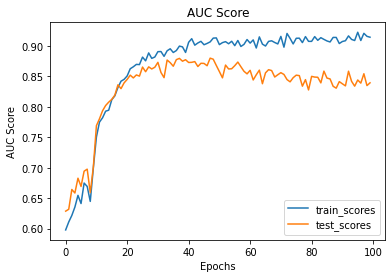

In [24]:
plot_train_stats(params_deepl)